In [1]:
import pints
import pints.toy as toy
import pints.plot

import emupints
import emupints.plot as emuplt
import emupints.utils as emutils
import emupints.metrics as emumet

from emupints.models import create_small_model, create_average_model, create_large_model

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras

import string

# Problem parameters

In [2]:
# Load problem from predefined ones
model = emupints.Problems.GoodwinOscillatorModel
problem = emupints.Problems.load_problem(model)

problem['values'][:5]

array([[0.00601086, 0.05671221, 1.89336256],
       [0.0061671 , 0.05812419, 1.86550273],
       [0.00592018, 0.06126844, 1.88445274],
       [0.00623554, 0.06272704, 2.00359124],
       [0.00607212, 0.06903719, 2.00840335]])

In [3]:
# take all the required variables from the problem
n_parameters = problem['n_parameters']
log_likelihood = problem['log_likelihood']
log_prior = problem['log_prior']
log_posterior = problem['log_posterior']
real_parameters = problem['parameters']
pints_problem = problem['problem']
bounds = problem['bounds']
index_to_param_name = problem['param_names']

# Apply CMA-ES

In [4]:
# CMA-es
score = pints.SumOfSquaresError(pints_problem)
x0 = bounds.sample(1)[0]

found_parameters, found_value = pints.optimise(
    score,
    x0,
    None,
    bounds,
    method=pints.CMAES
)

Minimising error measure
using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 8
Iter. Eval. Best      Time m:s
0     8      1.11142    0:00.1
1     16     0.967601   0:00.1
2     24     0.967601   0:00.1
3     32     0.967601   0:00.1
20    168    0.877      0:00.5
40    328    0.791      0:00.8
60    488    0.726822   0:01.2
80    648    0.725      0:01.5
100   808    0.725      0:01.9
120   968    0.725      0:02.2
140   1128   0.725      0:02.5
160   1288   0.725      0:02.9
180   1448   0.725      0:03.2
200   1608   0.725      0:03.5
220   1768   0.725      0:03.9
240   1928   0.724721   0:04.2
260   2088   0.724721   0:04.5
280   2248   0.724721   0:04.8
300   2408   0.724721   0:05.2
320   2568   0.724721   0:05.5
340   2728   0.724721   0:05.8
360   2888   0.724721   0:06.2
380   3048   0.724721   0:06.5
400   3208   0.724721   0:06.9
420   3368   0.724721   0:07.2
440   3528   0.724721   0:07.5
460   3688   0.724721   0:07

# Use found parameters to sample trianing data

In [5]:
# training size
# use bigger training size for NNs because speed stays the same
train_size = 3000
test_size = 400
sampling_std = 0.05 * found_parameters # take 0.05% around found parameters std

def normal_sampling(size, mean, std):
    return mean + np.random.randn(*size) * std

# create data for training and testing
# genera example using normal distribution around parametrs
train_X = normal_sampling((train_size, n_parameters), found_parameters, sampling_std)
train_y = np.apply_along_axis(log_likelihood, 1, train_X)

# if provide validation data to keras model also need to normalize it 
test_X = normal_sampling((test_size, n_parameters), found_parameters, sampling_std)
test_y = np.apply_along_axis(log_likelihood, 1, test_X)

# Create NN emulator

In [6]:
EPOCHS = 50
BATCH = 32
validation_split = 0.2

In [7]:
# how to scale data
# for input use standardisation, same as GPs
# for output scale linearly in range (-1, 1)
input_scaler = MinMaxScaler(feature_range=(-1, 1))
output_scaler = StandardScaler()

In [8]:
emu = emupints.NNEmulator(log_likelihood, 
                          train_X,
                          train_y,
                          model_size='small',
                          input_scaler=input_scaler, 
                          output_scaler=output_scaler
                         )

In [9]:
# print summary of the model
emu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                384       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 17,025
Trainable params: 17,025
Non-trainable params: 0
_________________________________________________________________


In [10]:
# store best
mc_callback = keras.callbacks.ModelCheckpoint("models/model_{epoch:02d}.h5", 
                                              save_weights_only=True,  
                                             )

In [11]:
# store the results during training
val_umae = []

# Callback to calculate unormalized mae
class UnormalizedMAE(keras.callbacks.Callback):

    def on_epoch_end(self, batch, logs={}):
        X_val, y_val = self.validation_data[0], self.validation_data[1]
        
        y_val_predict = np.asarray(self.model.predict(X_val))

        # unormalize predictions
        y_val = output_scaler.inverse_transform(y_val)
        y_val_predict = output_scaler.inverse_transform(y_val_predict)

        # calculate mae
        mae_val = np.mean(np.abs(y_val - y_val_predict))

        # store results
        val_umae.append(mae_val)

        return

In [12]:
#optimizer = tf.train.RMSPropOptimizer(learning_rate)
emu.set_parameters(
    loss='mse',
    optimizer='adam',
    metrics=['mae'] # mean absolute error
)

In [13]:
history = emu.fit(epochs=EPOCHS,
                  batch_size=BATCH,
                  validation_split=0.2,
                  callbacks=[mc_callback,UnormalizedMAE()],
                 )

Train on 2400 samples, validate on 600 samples
Epoch 1/50
2400/2400 [==============================] - 0s 172us/step - loss: 2.0946 - mean_absolute_error: 0.6506 - val_loss: 1.1278 - val_mean_absolute_error: 0.4217
Epoch 2/50
2400/2400 [==============================] - 0s 46us/step - loss: 0.8141 - mean_absolute_error: 0.2517 - val_loss: 0.5193 - val_mean_absolute_error: 0.1625
Epoch 3/50
2400/2400 [==============================] - 0s 44us/step - loss: 0.4482 - mean_absolute_error: 0.1565 - val_loss: 0.3434 - val_mean_absolute_error: 0.1203
Epoch 4/50
2400/2400 [==============================] - 0s 43us/step - loss: 0.3299 - mean_absolute_error: 0.1324 - val_loss: 0.2659 - val_mean_absolute_error: 0.1014
Epoch 5/50
2400/2400 [==============================] - 0s 45us/step - loss: 0.2630 - mean_absolute_error: 0.1099 - val_loss: 0.2244 - val_mean_absolute_error: 0.0903
Epoch 6/50
2400/2400 [==============================] - 0s 49us/step - loss: 0.2247 - mean_absolute_error: 0.0982 - v

2400/2400 [==============================] - 0s 41us/step - loss: 0.0916 - mean_absolute_error: 0.0675 - val_loss: 0.0890 - val_mean_absolute_error: 0.0786
Epoch 50/50
2400/2400 [==============================] - 0s 41us/step - loss: 0.0896 - mean_absolute_error: 0.0621 - val_loss: 0.0875 - val_mean_absolute_error: 0.0604


In [14]:
best_model_idx = np.argmin(val_umae)
emu._model.load_weights("models/model_{:02d}.h5".format(best_model_idx))

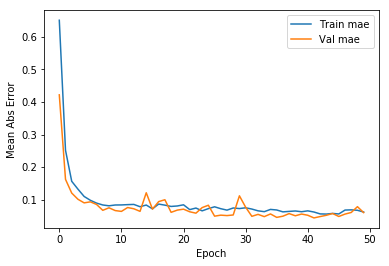

In [15]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
       label='Train mae')
plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
       label = 'Val mae')
plt.legend()

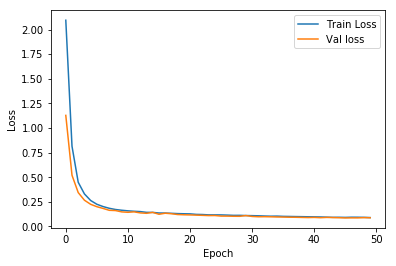

In [16]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.epoch, np.array(history.history['loss']),
       label='Train Loss')
plt.plot(history.epoch, np.array(history.history['val_loss']),
       label = 'Val loss')
plt.legend()

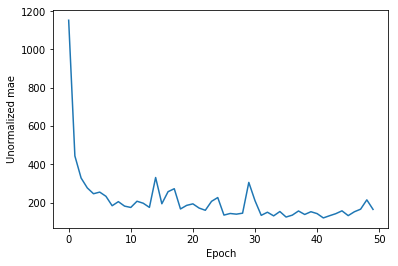

In [17]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Unormalized mae')
plt.plot(history.epoch, val_umae)

# Likelihood metrics

In [18]:
emu_time = %timeit -r 50 -o emu(real_parameters)
print("Emulator prediction time (micro-seconds): {:5f}".format(emu_time.average * 1000000))

506 µs ± 160 µs per loop (mean ± std. dev. of 50 runs, 1000 loops each)
Emulator prediction time (micro-seconds): 505.760826


In [19]:
likelihood_time = %timeit -r 50 -o log_likelihood(real_parameters)
print("Likelihood prediction time (micro-seconds): {:5f}".format(likelihood_time.average * 1000000))

2.28 ms ± 295 µs per loop (mean ± std. dev. of 50 runs, 1000 loops each)
Likelihood prediction time (micro-seconds): 2284.299878


In [20]:
pred_y = np.apply_along_axis(emu, 1, test_X)
print("Mean absolute error (mae): {:.5f}".format(emumet.mae(test_y, pred_y)))

Mean absolute error (mae): 2475.12008


In [21]:
print("Mean percentage error (mape): {:.5f}".format(emumet.mape(test_y, pred_y) * 100))

Mean percentage error (mape): 284.48978


# Comparing MCMC run times

In [22]:
mcmc_method = pints.AdaptiveCovarianceMCMC

# MCMC parameters
num_chains = 3
max_iters = 10000

In [23]:
# Create a posterior log-likelihood (log(likelihood * prior))
emu_log_posterior = pints.LogPosterior(emu, log_prior)

In [24]:
xs = [
    found_parameters,
    found_parameters * 1.01,
    found_parameters * 0.99
]
xs

[array([2.0213724 , 3.90616272, 0.12061771, 0.08150482, 0.0980328 ]),
 array([2.04158613, 3.94522435, 0.12182388, 0.08231987, 0.09901313]),
 array([2.00115868, 3.86710109, 0.11941153, 0.08068977, 0.09705247])]

In [25]:
emu_mcmc = pints.MCMCSampling(emu_log_posterior,
                              num_chains,
                              xs,
                              method = mcmc_method,
                             )
emu_mcmc.set_log_to_screen(False)
print('Running...')
emu_chains = emu_mcmc.run()
print('Done!')

Running...
Done!


In [26]:
real_mcmc = pints.MCMCSampling(log_posterior, 
                               num_chains, 
                               xs, 
                               method = mcmc_method,
                               )
real_mcmc.set_max_iterations(max_iters)
real_mcmc.set_log_to_screen(False)
# Run!
print('Running...')
real_chains = real_mcmc.run()
print('Done!')

Running...
Done!


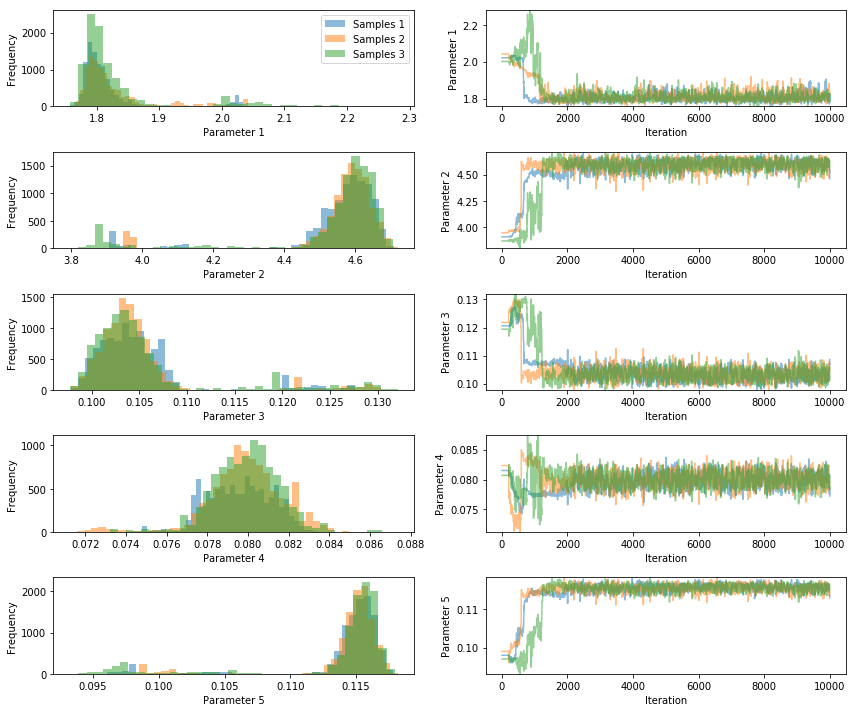

In [27]:
pints.plot.trace(emu_chains)
plt.show()

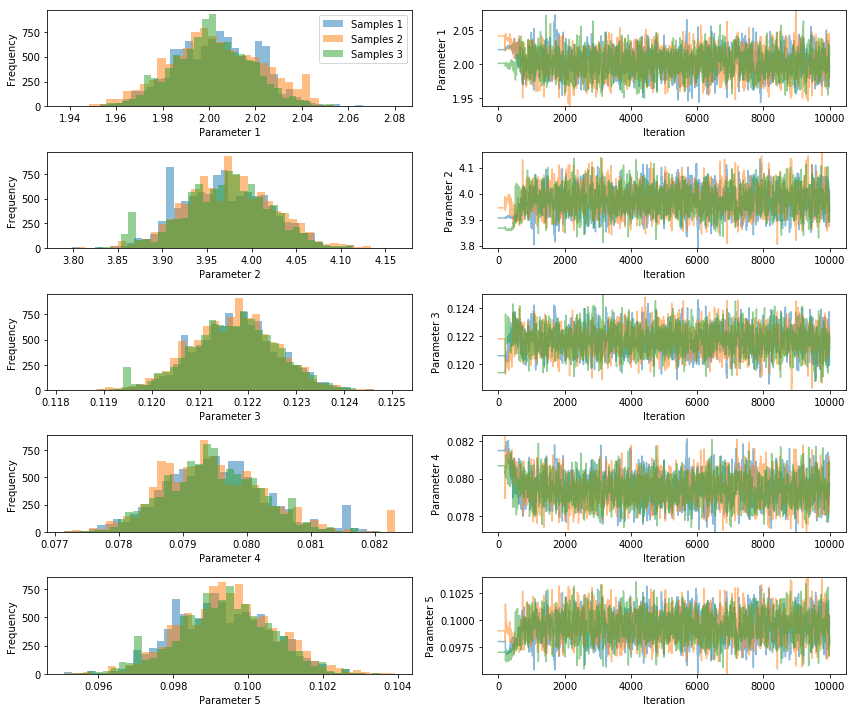

In [28]:
pints.plot.trace(real_chains)
plt.show()

# MCMC metrics

In [29]:
print('Emulator R-hat:')
print(pints.rhat_all_params(emu_chains))

Emulator R-hat:
[1.007904849617367, 1.0035264660181145, 1.001677421576875, 1.0072203380517872, 1.0051054631961351]


In [30]:
print('Real R-hat:')
print(pints.rhat_all_params(real_chains))

Real R-hat:
[1.001685483880064, 1.0027175274356037, 1.0006622147212978, 1.000380051446079, 1.0029879383246982]


In [31]:
# percentage
chain = real_chains[0]

chain_mape = emumet.chain_mape(chain, emu, log_likelihood)
print("Chain mean absolute percentage error: {:.5f}".format(chain_mape * 100))

Chain mean absolute percentage error: 1.43826


In [32]:
emu_mcmc_time = %timeit -o emu_mcmc.run()
print("Emulator MCMC time: {:.5f}".format(emu_mcmc_time.average))

22.1 s ± 2.29 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Emulator MCMC time: 22.13851


In [33]:
real_mcmc_time = %timeit -o real_mcmc.run()
print("MCMC time: {:.5f}".format(real_mcmc_time.average))

1min 8s ± 5.2 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
MCMC time: 68.80616


In [34]:
emu_parameters, emu_parameters_std = emumet.estimate_parameters(emu_chains)
print("Emulator estimated parameters: ", emu_parameters)
print("Emulator parametet std: ", emu_parameters_std)

Emulator estimated parameters:  [1.82647148 4.54016077 0.10509933 0.07979823 0.11404231]
Emulator parametet std:  [0.01240808 0.02646555 0.00069658 0.00015198 0.00081255]


In [35]:
real_parameters, real_parameters_std = emumet.estimate_parameters(real_chains)
print("Estimated parameters: ", real_parameters)
print("parametet std: ", real_parameters_std)

Estimated parameters:  [2.00264223 3.9720641  0.1217043  0.07950009 0.0993649 ]
parametet std:  [1.39945484e-03 1.42381313e-04 2.25589825e-05 5.82939868e-05
 4.38436015e-06]


# Plotting emulator surfaces around parameters

In [36]:
# use smaller bounds to get an idea of the surface around real parameters
min_bounds = np.min(chain, axis = 0)
max_bounds = np.max(chain, axis = 0)
bounds = pints.RectangularBoundaries(min_bounds, max_bounds)

In [37]:
bounds

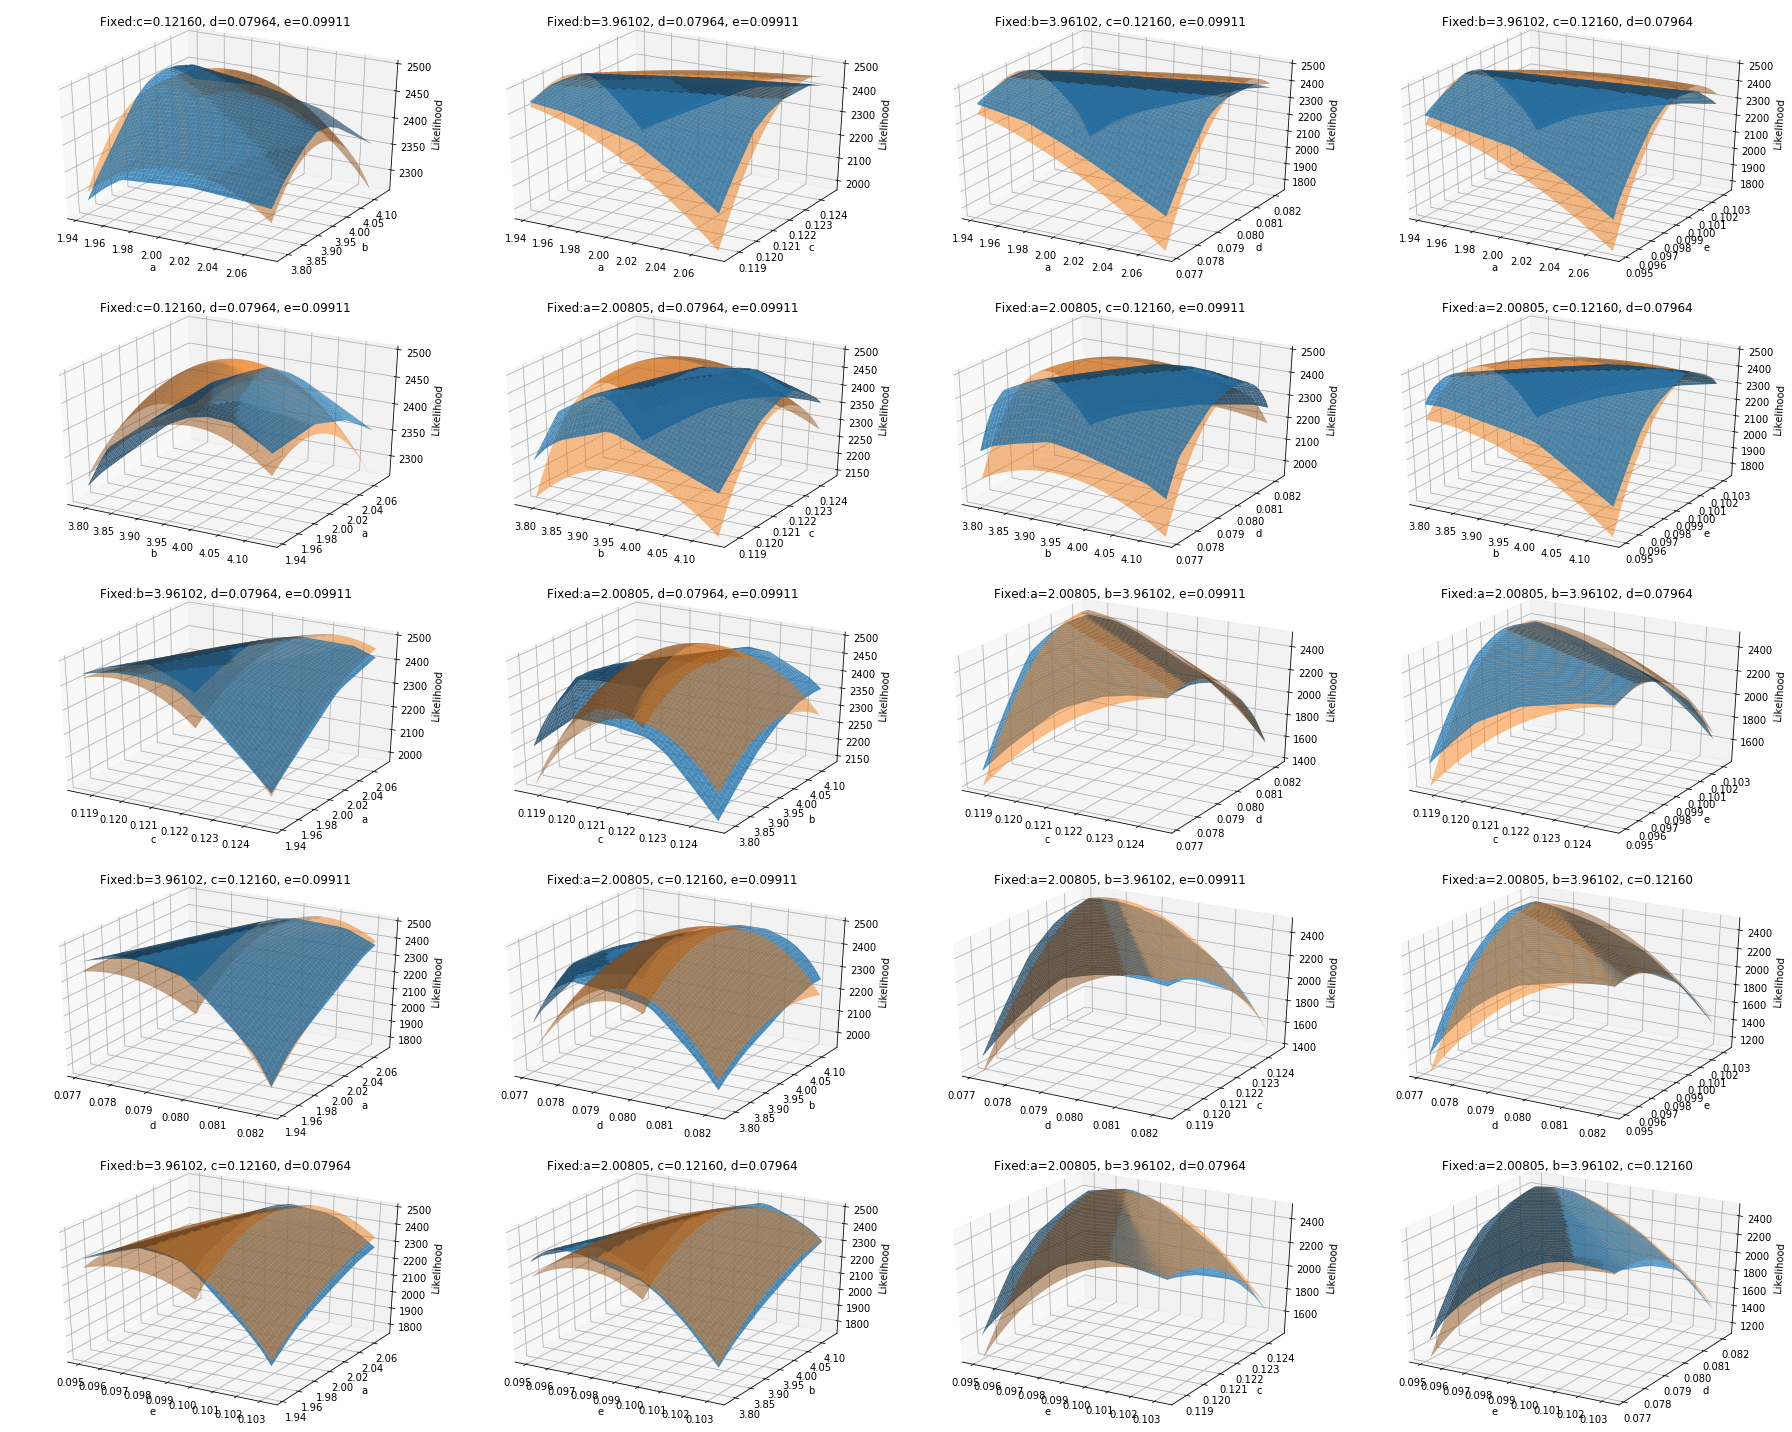

In [38]:
# plot surfaces
if n_parameters >= 3:
    fixed_parameters = emutils.fix_parameters(bounds)
    
    fig, ax = emuplt.plot_fixed_param_grid(
        emu,
        fixed_parameters,
        bounds,
        shape = (n_parameters, n_parameters - 1),
        contour = False,
        index_to_param_name=index_to_param_name,
        additional_log_likelihoods = [log_likelihood]
    )

    plt.show(fig)
    
# for row i we have parameter i fixed and some other parameter j, depending on the column, j != i

In [39]:
print(bounds.lower())
print(bounds.upper())

[1.94315844 3.78969656 0.11859314 0.07714551 0.09508105]
[2.07293442 4.13234699 0.12461305 0.08213589 0.10313971]


In [40]:
fig, ax = emuplt.plot_surface_fixed_param(
    emu,
    bounds,
    fixed = [(0, 0.01), (1, 10), (3, 0.125)],
    index_to_param_name=index_to_param_name,
    contour=False,
    precision=2,
    additional_log_likelihoods=[log _likelihood]
)

SyntaxError: invalid syntax (<ipython-input-40-270388de9ee0>, line 8)

In [ ]:
ax.view_init(30, 20 + 90 * 3)
fig.set_size_inches(10.5, 6)
fig